In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

In [2]:
df = pd.read_csv('./Thyroid_Diff.csv')

df.columns = df.columns.str.replace(' ', '')

# replace recurred with 0s and 1s so that we can see recurrence rate when grouping by independent variables
df.Recurred = df.Recurred.replace({'No': 0, 'Yes': 1})
df.head()

,Age,Gender,Smoking,HxSmoking,HxRadiothreapy,ThyroidFunction,PhysicalExamination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,0
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,0


In [3]:
print("Over recurrence rate:", (df.Recurred.mean() * 100))

Over recurrence rate: 28.198433420365536


# Continuous Variable Exploration

The only continuous variable in the dataset is age.  Let's explore its relationship with the dependent variable, recurrence.

In [4]:
df.groupby('Recurred').mean(numeric_only = True)

,Age
Recurred,
0,38.414545
1,47.111111


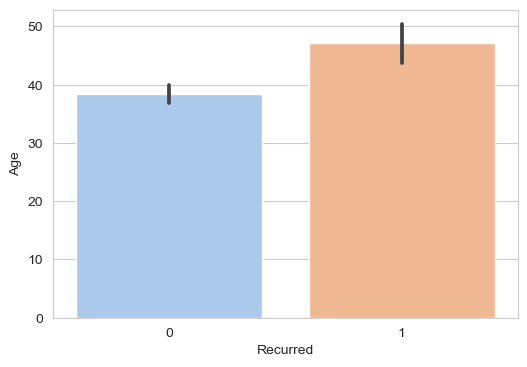

In [5]:
plt.figure(figsize = (6,4))

sns.barplot(data = df, x = 'Recurred', y = 'Age')
plt.show()

# Categorical Variable Exploration

In [6]:
df.groupby('Smoking').aggregate({'Recurred': 'mean'})

,Recurred
Smoking,
No,0.224551
Yes,0.673469


In [7]:
df.groupby('HxRadiothreapy').aggregate({'Recurred': 'mean'})

,Recurred
HxRadiothreapy,
No,0.271277
Yes,0.857143


In [8]:
df.groupby('ThyroidFunction').aggregate({'Recurred': ['mean', 'count']})

Recurred      
                                 mean count
ThyroidFunction                            
Clinical Hyperthyroidism     0.150000    20
Clinical Hypothyroidism      0.166667    12
Euthyroid                    0.295181   332
Subclinical Hyperthyroidism  0.000000     5
Subclinical Hypothyroidism   0.357143    14

In [9]:
df.groupby('PhysicalExamination').aggregate({'Recurred': ['mean', 'count']})

Recurred      
                                 mean count
PhysicalExamination                        
Diffuse goiter               0.000000     7
Multinodular goiter          0.371429   140
Normal                       0.285714     7
Single nodular goiter-left   0.292135    89
Single nodular goiter-right  0.200000   140

In [10]:
df.groupby('Adenopathy').aggregate({'Recurred': ['mean', 'count']})

Recurred      
                mean count
Adenopathy                
Bilateral   0.843750    32
Extensive   1.000000     7
Left        0.705882    17
No          0.108303   277
Posterior   1.000000     2
Right       0.625000    48

The Adenopathy columns just represents wether a patient has swollen glands.  So, we're going to code all answers other than no as 'Yes'

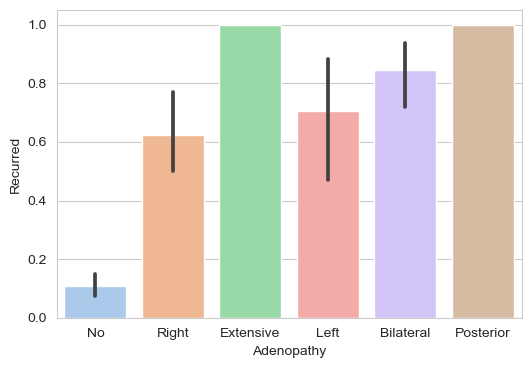

In [11]:
plt.figure(figsize = (6,4))

sns.barplot(data = df, x = 'Adenopathy', y = 'Recurred')
plt.show()

In [12]:
df.Adenopathy = df.Adenopathy.apply(lambda x: 0 if x.strip() == 'No' else 1)

df.groupby('Adenopathy').aggregate({'Recurred': ['mean', 'count']})

Recurred      
                mean count
Adenopathy                
0           0.108303   277
1           0.735849   106

In [13]:
df.groupby('T').aggregate({'Recurred': ['mean', 'count']})

Recurred      
         mean count
T                  
T1a  0.020408    49
T1b  0.116279    43
T2   0.132450   151
T3a  0.427083    96
T3b  0.875000    16
T4a  0.950000    20
T4b  1.000000     8

In [14]:
df.groupby('Stage').aggregate({'Recurred': ['mean', 'count']})

Recurred      
           mean count
Stage                
I      0.195195   333
II     0.781250    32
III    1.000000     4
IVA    1.000000     3
IVB    1.000000    11

# Features

Some of the columns have an ordinal relationship, that is their ordering is important.  For example, the later the stage of cancer the higher the rate of recurrence.

Or, a column only has two categories, in which case an ordinal encoder will make sense to use here as well.

Other columns do not possess this relationship, therefore a One Hot Encoder will make more sense for these columns

Ordinal columns:
> 1. Gender
> 2. Smoking
> 3. HxSmoking
> 4. HxRadiotherapy
> 5. Focality
> 6. Risk
> 7. T, N, M
> 8. Stage
> 9. Response

Categorical Columns:
> 1. Thyroid Function
> 2. Physical Examination
> 3. Pathology

Feature Selection: After examining the independent variables, every variable seems to impact recurrence rate with the exception of thyroid function and physical examination.  Let's try building a model that includes all columns with the exception of thryoid function and physical examination

# Data Pipelines

## Ordinal Data Pipeline

In [15]:
ordinal_cols = ['Gender', 'Smoking', 'HxSmoking', 'HxRadiothreapy', 'Focality', 
                'Risk', 'T', 'N', 'M', 'Stage', 'Response']

ordinal = df[ordinal_cols]

ordinal_pipeline = Pipeline([
    ('ordinal encoder', OrdinalEncoder())
])

ordinal_tr = ordinal_pipeline.fit_transform(ordinal)
ordinal_tr

array([[0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 1., 4., 3.],
       [1., 1., 1., ..., 0., 3., 3.],
       [1., 1., 0., ..., 0., 3., 3.]])

## Categorical Data Pipeline

In [16]:
cat_cols = ['ThyroidFunction', 'PhysicalExamination', 'Pathology']

cat = df[cat_cols]

cat_pipeline = Pipeline([
    ('one hot encoder', OneHotEncoder())
])

cat_tr = cat_pipeline.fit_transform(cat)
cat_tr = cat_tr.toarray()
cat_tr

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

## Numerical Data Pipeline

In [17]:
num_cols = ['Age', 'Adenopathy']

num = df[num_cols]

num_pipeline = Pipeline([
    ('scale', StandardScaler())
])

num_tr = num_pipeline.fit_transform(num)
num_tr[0:5]

array([[-0.91743929, -0.61860446],
       [-0.45431469, -0.61860446],
       [-0.71895732, -0.61860446],
       [ 1.39818369, -0.61860446],
       [ 1.39818369, -0.61860446]])

## Full Pipeline

In [18]:
full_pipeline = ColumnTransformer([
    ('ordinal', ordinal_pipeline, ordinal_cols),
    ('categorical', cat_pipeline, cat_cols),
    ('numerical', num_pipeline, num_cols)
])

data_prepared = full_pipeline.fit_transform(df)
data_prepared

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.91743929, -0.61860446],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.45431469, -0.61860446],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.71895732, -0.61860446],
       ...,
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         2.05979025,  1.61654185],
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         1.33202303,  1.61654185],
       [ 1.        ,  1.        ,  0.        , ...,  1.        ,
         1.72898697,  1.61654185]])

# Machine Learning Model

In [19]:
X = data_prepared
y = df.Recurred

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 21)

xgb = XGBClassifier(n_estimators = 100, max_depth = 10, gamma = 1, learning_rate = .1)

In [20]:
xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Prediction Metrics

In [21]:
predictions = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))

Accuracy: 0.974025974025974
Precision: 0.95
Recall: 0.95


## Hypertune Parameters using Cross-Validation

In [22]:
# perform grid search to tune hyperparameters
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [6, 10],
    "gamma": [1, 5],
    "learning_rate": [.1, .5]
}

xgb = XGBClassifier()

grid = GridSearchCV(xgb, param_grid = params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_chi

In [23]:
grid.best_params_

{'gamma': 1, 'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 50}

In [24]:
# retrain model with the hypertuned parameters
tuned_model = XGBClassifier(n_estimators = grid.best_params_["max_depth"], max_depth = grid.best_params_["n_estimators"],
                      gamma = grid.best_params_["gamma"], learning_rate = grid.best_params_["learning_rate"])
tuned_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=6, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [25]:
predictions = tuned_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))

Accuracy: 0.961038961038961
Precision: 0.9473684210526315
Recall: 0.9
